### I :

1. feature extraction
    - word2vec
    - unform sampling 
2. logistic regression training
3. evaluate


### II :

1. feature extraction
    - bert based feat extraction
    - unform sampling 
2. logistic regression training
3. evaluate


In [18]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
import numpy as np
from datasets import load_dataset
torch.__version__

'1.10.1+cu113'

# Tokenizer

In [2]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

Below we will load the full model including LM head for fine tuning. During the prediction we will not use the prediction part.

In [3]:
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

/home/ikhtiyor/anaconda3/envs/epytorch/lib/python3.7/site-packages/transformers/models/auto/modeling_auto.py:1181: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [4]:
text = ["I would love to attend this challenge", "i hate that", "loving it"]
enc = tokenizer(text, padding=True)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

In [5]:
# input ids are numerical encoding of the words in the vocabulary.
# attention mask indicates the position of the paddings so that the model does not pay attention to them
enc

{'input_ids': [[0, 100, 74, 657, 7, 2725, 42, 1539, 2], [0, 118, 4157, 14, 2, 1, 1, 1, 1], [0, 23760, 24, 2, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 0]]}

run test run with the example data. here 768 is the vocab_size.

In [6]:
out = base_model(torch.tensor(enc["input_ids"]), torch.tensor(enc["attention_mask"]))
out[0].shape

torch.Size([3, 9, 768])

In [7]:
t = "I would love to attend this challenge"
enc = tokenizer(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 100, 74, 657, 7, 2725, 42, 1539, 2]
<s>I would love to attend this challenge</s>
Length: 9
torch.Size([9, 768])


# Our custom model

Use Mish activiation function as in the one proposed in the original tutorial

In [8]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))
  
class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [9]:
class EmotionModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.5):
        super().__init__()
        self.base_model = base_model
        self.n_classes = n_classes
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)            
        )
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if(layer.bias is not None):
                    layer.bias.data.zero_()
    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask = attention_mask)
        # TODO apply some magic stuff here (like RNNS )
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

## Pretest the model with dummy text
We want to make sure that the model is returning the right stuff

In [10]:
classifier = EmotionModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 3)

In [11]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [12]:
classifier((X, attn))

tensor([[-0.3027, -0.1591, -0.2603]], grad_fn=<AddmmBackward0>)

# Prepare the dataset for finetuning 

In [13]:
# load pretrained tokenizer information
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [14]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


In [16]:
# this code makes sure the input data is in correct format
# copied from https://colab.research.google.com/drive/1nwCE6b9PXIKhv2hvbqf1oZKIGkXMTi1X#scrollTo=3SCLBZsMDn4s
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [21]:
# load the dataset
dataset = load_dataset("dair-ai/emotion")
dataset.set_format(type="pandas")
train_df = dataset['train'][:]
val_df = dataset['validation'][:]
test_df = dataset['test'][:]

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/ikhtiyor/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}
labels_dict = {0:'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]
train_df['emotions']= train_df.label.map(labels_dict)
val_df['emotions']= train_df.label.map(labels_dict)
test_df['emotions']= train_df.label.map(labels_dict)

<AxesSubplot:>

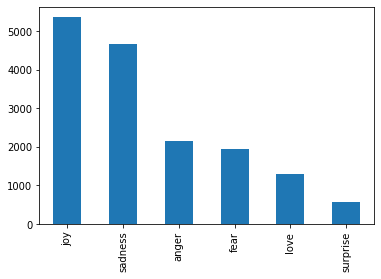

In [35]:
# as you can see there is class inbalance
train_df.emotions.value_counts().plot.bar()

In [37]:
train_df.head()

,text,label,emotions
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [38]:
## check unique emotions in the dataset
train_df.emotions.unique(), val_df.emotions.unique(), test_df.emotions.unique()

(array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
       dtype=object),
 array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
       dtype=object),
 array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
       dtype=object))

## Dataset Object 


In [51]:
class EmotionDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.data_column = 'text'
        self.class_column = 'label'
        self.data = df
    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], self.data.loc[idx, self.class_column]
    
    def __len__(self):
        return self.data.shape[0]

In [52]:
# test 
ds = EmotionDataset(train_df)
ds[19]

('i now feel compromised and skeptical of the value of every unit of work i put in',
 4)

# Training

In [94]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmotionModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 
                                  len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        pred = self.forward(X)        
        loss = self.loss(pred, y)
        pred = torch.softmax(pred, 1).argmax(1)
        acc = (pred == y).sum().cpu().numpy()/len(y)
        loss_key = f"{step_name}_loss"
        acc_key = f"{step_name}_accuracy"
        tensorboard_logs = {loss_key: loss, acc_key: acc}
        print(step_name, acc)
        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss, acc_key: acc}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_df, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_df)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_df)
                
    def create_data_loader(self, df: pd.DataFrame, shuffle=False):
        return DataLoader(
                    EmotionDataset(df),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

In [95]:
lr = 1e-4 
lr

0.0001

In [96]:
hparams = Namespace(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    batch_size=1,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

In [97]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [98]:
## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, 
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | EmotionModel     | 82.1 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
82.1 M    Trainable params
0         Non-trainable params
82.1 M    Total params
328.492   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

val 0.0
val 0.0


Training: 0it [00:00, ?it/s]

train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0


train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 1.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0


train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 1.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 1.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0


train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 1.0
train 1.0
train 0.0
train 1.0
train 1.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 1.0
train 0.0
train 1.0
train 1.0
train 1.0
train 0.0
train 1.0
train 0.0
train 0.0
train 1.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
train 1.0
train 1.0
train 1.0
train 0.0
train 1.0
train 0.0
train 1.0
train 0.0
train 0.0
train 0.0
train 0.0
train 0.0
train 1.0
